In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from graph_tool.all import *
from graph_tool.draw import *

import heapq
import requests
import json
import time
import csv

In [2]:
def hex_to_int(id):
    '''Map patent id (string) to graph id (int).'''
    return int(id, 16)

def int_to_hex(id):
    '''Map graph id (int) to patent id (string).'''
    return '{0:0x}'.format(id)

In [2]:
DATA = './data/'
graph = load_graph(DATA + 'citations_graph.xml.gz')
graph

<Graph object, directed, with 8274991 vertices and 86284396 edges at 0x7fdfa55772b0>

In [4]:
# Getting the in-degree of each vertex
vertices = [int(v) for v in graph.vertices()]
in_deg = graph.get_in_degrees(vertices)

In [ ]:
highest_in = []

max_in_degs = heapq.nlargest(1000, enumerate(in_deg), key=lambda x: x[1])

for idx, deg in enumerate(max_in_degs):
    patent_id = int_to_hex(graph.vp.id[deg[0]])
    patent_URL = 'http://www.patentsview.org/api/patents/query?q={"patent_number":"' + patent_id + '"}'
    patent_info = requests.get(patent_URL).json()
    if patent_info['patents']:
        patent_title = patent_info['patents'][0]['patent_title']
    else:
        patent_title = '- No title available -'
    in_degree = deg[1]
    highest_in.append([patent_id, in_degree, patent_title])
    if idx % 100 == 0:
        print(idx)

In [ ]:
highest_in = np.array(highest_in)

In [55]:
output_file = open('highest_in.csv', 'w')
with output_file:  
    writer = csv.writer(output_file)
    writer.writerow(['patent_id', 'in_degree', 'patent_title'])
    writer.writerows(highest_in)

In [56]:
pr = pagerank(graph)

In [60]:
highest_pr = []

max_pr = heapq.nlargest(1000, enumerate(pr), key=lambda x: x[1])

for idx, deg in enumerate(max_pr):
    patent_id = int_to_hex(graph.vp.id[deg[0]])
    patent_URL = 'http://www.patentsview.org/api/patents/query?q={"patent_number":"' + patent_id + '"}'
    patent_info = requests.get(patent_URL).json()
    if patent_info['patents']:
        patent_title = patent_info['patents'][0]['patent_title']
    else:
        patent_title = '- No title available -'
    rank = deg[1]
    highest_pr.append([patent_id, rank, patent_title])
    if idx % 100 == 0:
        print(idx)

0
100
200
300
400
500
600
700
800
900


In [65]:
highest_pr = np.array(highest_pr)

In [63]:
output_file = open('highest_pr.csv', 'w')
with output_file:  
    writer = csv.writer(output_file)
    writer.writerow(['patent_id', 'pagerank', 'patent_title'])
    writer.writerows(highest_pr)

In [3]:
top_in_deg = pd.read_csv('highest_in.csv')
top_in_deg.patent_id = top_in_deg.patent_id.apply(str)
top_pr = pd.read_csv('highest_pr.csv')
top_pr.patent_id = top_pr.patent_id.apply(str)

In [4]:
top_in_deg.head()

,patent_id,in_degree,rank_in,patent_title_in
0,4683202,3709,1,Process for amplifying nucleic acid sequences
1,5523520,3342,2,Mutant dwarfism gene of petunia
2,4683195,3188,3,"Process for amplifying, detecting, and/or-clon..."
3,4733665,2697,4,"Expandable intraluminal graft, and method and ..."
4,5892900,2451,5,Systems and methods for secure transaction man...


In [5]:
top_pr.head()

,patent_id,pagerank,rank_pr,patent_title_pr
0,4237224,0.000029,1,Process for producing biologically functional ...
1,3813316,0.000025,2,- No title available -
2,4309756,0.000019,3,Method of automatically evaluating source lang...
3,4558413,0.000018,4,Software version management system
4,4395486,0.000017,5,Method for the direct analysis of sickle cell ...


In [6]:
merged = top_in_deg.merge(top_pr, on='patent_id', how='inner')

In [10]:
merged['rank_avg'] = (merged.rank_in + merged.rank_pr) / 2

In [15]:
merged = merged.sort_values('rank_avg')

In [16]:
merged.head(10)

,patent_id,in_degree,rank_in,patent_title_in,pagerank,rank_pr,patent_title_pr,rank_avg
0,4683202,3709,1,Process for amplifying nucleic acid sequences,0.000017,6,Process for amplifying nucleic acid sequences,3.5
2,4683195,3188,3,"Process for amplifying, detecting, and/or-clon...",0.000017,7,"Process for amplifying, detecting, and/or-clon...",5.0
1,5523520,3342,2,Mutant dwarfism gene of petunia,0.000013,10,Mutant dwarfism gene of petunia,6.0
7,4723129,1871,31,Bubble jet recording method and apparatus in w...,0.000008,34,Bubble jet recording method and apparatus in w...,32.5
8,5572643,1811,34,Web browser with dynamic display of informatio...,0.000008,36,Web browser with dynamic display of informatio...,35.0
12,4463359,1680,38,Droplet generating method and apparatus thereof,0.000008,32,Droplet generating method and apparatus thereof,35.0
19,5103459,1554,48,System and method for generating signal wavefo...,0.000009,23,System and method for generating signal wavefo...,35.5
33,4901307,1407,67,Spread spectrum multiple access communication ...,0.000008,29,Spread spectrum multiple access communication ...,48.0
17,4740796,1587,46,Bubble jet recording method and apparatus in w...,0.000006,83,Bubble jet recording method and apparatus in w...,64.5
21,4558333,1476,51,Liquid jet recording head,0.000006,103,Liquid jet recording head,77.0


In [17]:
merged.to_csv('./top_merged.csv')

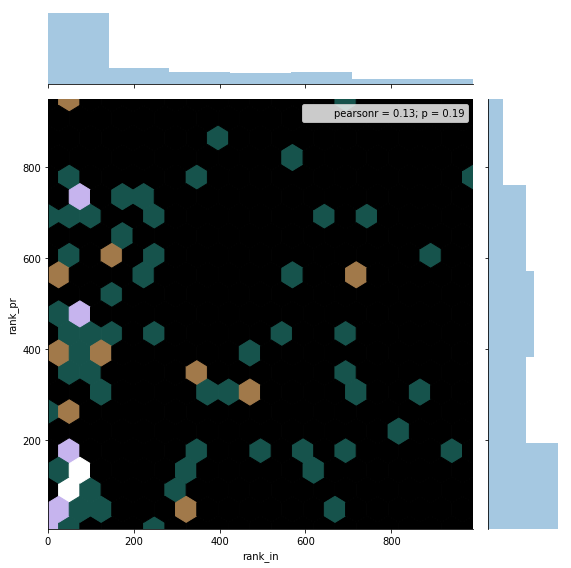

In [8]:
sns.jointplot(x='rank_in', y='rank_pr', data=merged, kind='hex', cmap= 'cubehelix', size=8, gridsize=20)